# 5 Урок: A/b-тесты
---


## Задание №1: АА-тест

**Описание:** нам нужно убедится, что наша система сплитования работает корректно. Для это проведем АА-тест и посмотрим на результаты

**Цель:** у нас есть данные АА-теста с `2023-01-24` по `2023-01-30`. Вам нужно **сделать симуляцию**, как будто мы провели **10 000 АА-тестов**. На каждой итерации вам нужно **сформировать подвыборки без повторения в 500 юзеров из 2 и 3 экспериментальной группы**. Провести сравнение этих подвыборок t-testом.

 1. Построить гистограмму распределения получившихся 10000 p-values.

 2. Посчитать, какой процент p values оказался меньше либо равен 0.05

 3. Написать вывод по проведенному АА-тесту, корректно ли работает наша система сплитования.

 4. Пришлите ссылку на merge request c проведенным анализом.

---
## Добавим необходимые библиотеки и установим соединение

In [69]:
# добавим необходимые библиотеки

import pandas as pd
import pandahouse as ph
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

In [7]:
# 

sns.set(rc={'figure.figsize': (12, 9)})

In [3]:
# установим соединение 

con = {
    'host': '*****',
    'password': '*****',
    'user': '*****',
    'database': '*****'
}

## АА-тест

А нас есть данные АА-теста с `2023-01-24` по `2023-01-30`, а группы которые нас интересуют = 2 и 3

In [4]:
# напишем наш запрос к БД

query = '''

SELECT exp_group,
       user_id,
       sum(action = 'view') AS view,
       sum(action = 'like') AS like,
       like / view AS ctr
FROM simulator_20230220.feed_actions       
WHERE (toDate(time) >= '2022-01-24' AND toDate(time) <='2023-01-30')
      AND exp_group IN (2,3)
GROUP BY exp_group, user_id


'''

In [5]:
# поместим наши данные в переменную df

df = ph.read_clickhouse(query, connection=con)

In [10]:
# выведем данные на экран

df.head()

,exp_group,user_id,view,like,ctr
0,3,115383,200,64,0.320000
1,3,10326,131,30,0.229008
2,2,131473,148,26,0.175676
3,3,123580,170,21,0.123529
4,2,23985,66,12,0.181818


In [18]:
# посмотрим на размер нашиг групп

df.groupby('exp_group').count()

,user_id,view,like,ctr
exp_group,,,,
2,10234,10234,10234,10234
3,10368,10368,10368,10368


Размер в группах примерно одинаковвый.

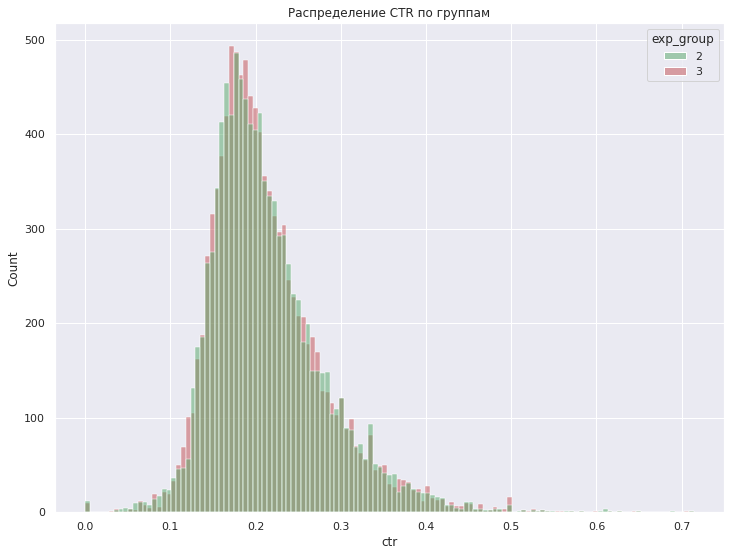

In [23]:
# посмотрим на распределение ctr в группах

plt.title('Распределение CTR по группам')
sns.histplot(data=df, x='ctr', hue='exp_group', palette=['g', 'r'], alpha= .5);

Визуально каких либо значимых отличий у распределений нет. Мы не наблюдаем какой-то явной скошенности или смещения. 

Проведем множественные t-тесты на псевдовыборках и узнаем их уровень p-value.

In [86]:
# проведем 10000 t-тестов из псевдовыборок по 500 значений в каждой без повторений в них а результаты p-value запишем в переменную result

result = []

for i in range(10000):
    result.append(
        stats.ttest_ind(df[df.exp_group == 2].ctr.sample(500, replace=False),
                        df[df.exp_group == 3].ctr.sample(500, replace=False),
                        equal_var = False)[1])


In [87]:
# для удобства дальнейших расчетов переведем наш список в массив numpy.array

p_values = np.array(result)

In [88]:
# проверим размер наших расчетов, должно быть = 10000

p_values.size

10000

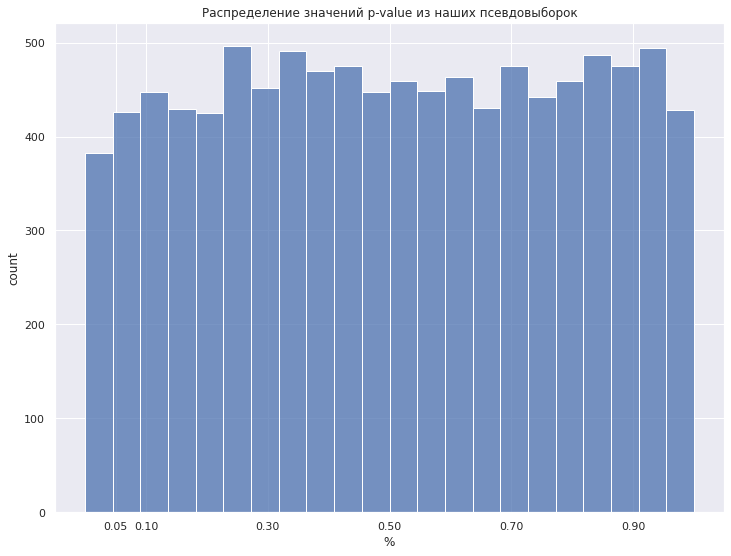

In [137]:
# теперь построим гистограмму распределений

plt.title('Распределение значений p-value из наших псевдовыборок')
plt.xlabel('%')
plt.ylabel('count')
sns.histplot(p_values)
plt.xticks(ticks=[.05, .1, .3, .5, .7, .9]);

По распределению мы видим, что в большинстве случаев уровень p-value выше отметки в 5% - это может говорить о корректной работе системы сплитования. Давайте еще, на всякий случай, посчитаем долю ложных срабатываний.

In [149]:
# расчитаем долю ложны срабатываний

print('''
Если мы отвергаем нулевую гипотезу при условии, что p_value < 0.05, 
то только приблизительно в 5% случаев у нас бы получались статистические значимые различия между группами

В нашем случае статистически значимые различия между двумя группами встречались в {:.2%} случаев.

'''.format(p_values[p_values <= .05].size / p_values.size))


Если мы отвергаем нулевую гипотезу при условии, что p_value < 0.05, 
то только приблизительно в 5% случаев у нас бы получались статистические значимые различия между группами

В нашем случае статистически значимые различия между двумя группами встречались в 4.31% случаев.




>**Вывод:**
>
> Cистема сплитования работает корректно. Из наших выборок мы извлекли **10000** подвыборок размером 500 каждая и провели t-тест для каждой. Далее мы построили гистограмму 
> распределения для наших p-values и высчитали процент статистически ложных срабатываний. Нам не удалось опровергнуть, что наши выбоки различны. Поэтому можем заметить, что наша 
> **система сплитования работает корректно**.  